In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from misc import h5file
from itertools import combinations
from pathlib import Path

import numpy as np
import jax.numpy as jnp
from numpy.random import default_rng
import scipy.io as sio
from scipy.optimize import curve_fit
from jaxfit import CurveFit
from statsmodels.api import OLS as SMOLS
import sympy
import pandas as pd

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

import pysindy as ps

from sympy import symbols, sympify, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from functools import partial

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    nobs2 = nobs / 2.0
    ssr = np.sum(np.abs(ground - prediction)**2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def BIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams

MAIN_SEED = 1234

In [2]:
noise_lv = 30
fp1 = "./IPI_output_files/Burgers/PMS_data.h5"
fp2 = "./IPI_output_files/Burgers/encoded_pde_names.yaml"

In [3]:
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

['X_pre', 'best_subsets', 'un', 'y_pre']


In [4]:
import yaml
# RDAE, noRDAE
with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['u*u_1',
 'u_11+u*u_1',
 'u_1+u_11+u*u_1',
 'u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11']

In [5]:
data = sio.loadmat('../Datasets/burgers.mat')

u_clean = data['usol'].real
x = data['x'][0].real
t = data['t'][:,0].real
dt = t[1]-t[0]; dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [6]:
def count_parameters(torch_model, onlyif_requires_grad=True):
    if onlyif_requires_grad:
        return sum(p.numel() for p in torch_model.parameters() if p.requires_grad)
    return sum(p.numel() for p in torch_model.parameters())

class Sine(nn.Module):
    def __init__(self, ):
        super(Sine, self).__init__()
    def forward(self, x):
        return torch.sin(x)

class TorchMLP(nn.Module):
    def __init__(self, dimensions, bias=True, activation_function=nn.Tanh(), bn=None, dropout=None):
        super(TorchMLP, self).__init__()
        # setup ModuleList
        self.model  = nn.ModuleList()
        for i in range(len(dimensions)-1):
            self.model.append(nn.Linear(dimensions[i], dimensions[i+1], bias=bias))
            if bn is not None and i!=len(dimensions)-2:
                self.model.append(bn(dimensions[i+1]))
                if dropout is not None:
                    self.model.append(dropout)
            if i==len(dimensions)-2: break
            self.model.append(activation_function)
        # weight init
        self.model.apply(self.xavier_init)

    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)

    def forward(self, x):
        for i, l in enumerate(self.model): 
            x = l(x)
        return x

In [7]:
class PhysicalConstraintCalculator(nn.Module):
    def __init__(self, symbolic_module, basic_vars, init_coefficients=None, learnable_coefficients=False):
        super(PhysicalConstraintCalculator, self).__init__()
        self.symbolic_module = symbolic_module
        self.basic_vars = basic_vars
        
        self.coefficients = init_coefficients
        self.learnable_coefficients = learnable_coefficients

        if self.coefficients is None:
            self.coefficients = torch.ones(len(symbolic_module.sympy())).float()
        else:
            self.coefficients = torch.tensor(data=self.coefficients).float()
        self.coefficients = nn.Parameter(self.coefficients).requires_grad_(self.learnable_coefficients)
        
        # printing
        if self.learnable_coefficients: print("Learnable coefficients:", self.coefficients)
        else: print("NOT learnable coefficients:", self.coefficients)
        print(symbolic_module.sympy())
        print("Basic variables:", self.basic_vars)

    def set_learnable_coefficients(self, learn):
        self.coefficients.requires_grad_(learn)
    
    def forward(self, input_dict):
        return self.symbolic_module(**input_dict)

class PINN(nn.Module):
    def __init__(self, solver, physics_calculator, lb, ub, 
                 domain_dimension=None, weak_pde_lib=None, effective_indices=None, 
                 ic_module=None):
        super(PINN, self).__init__()
        self.solver = solver
        self.physics_calculator = physics_calculator
        self.lb = lb
        self.ub = ub
        # Only to use weak_loss
        # spatial x temporal
        self.domain_dimension = domain_dimension
        self.weak_pde_lib = weak_pde_lib
        self.effective_indices = effective_indices
        self.weak_coeff_buffer = None
        # must not be None if X_train_initial is not None but y_train_initial is None
        self.ic_module = ic_module
        
    def forward(self, x, t):
        return self.solver(self.input_normalize(torch.cat([x, t],  dim=-1)))

    def calculate_physics(self, x, t):
        u = self.forward(x, t)
        u_t = self.gradients(u, t)[0]
        u_1 = self.gradients(u, x)[0]
        u_11 = self.gradients(u_1, x)[0]
        physics = self.physics_calculator({nameof(u):u, 
                                           nameof(u_1):u_1, 
                                           nameof(u_11):u_11})
        
        return u, u_t, physics
    
    def loss(self, x, t, y_input, X_train_initial=None, y_train_initial=None):
        u, u_t, physics = self.calculate_physics(x, t)
        coeff = self.physics_calculator.coefficients
        physics = (physics*coeff).sum(axis=-1)
        mse = F.mse_loss(u, y_input, reduction='mean')
        
        # initial condition (ic)
        if X_train_initial is not None:
            ic_u_pred = self.solver(self.input_normalize(X_train_initial))
            if y_train_initial is None:
                y_train_initial = self.ic_module(X_train_initial)
            ic_loss = F.mse_loss(ic_u_pred, y_train_initial, reduction='mean')
            mse = torch.add(mse, ic_loss)
            
        l_eq = F.mse_loss(u_t, physics, reduction='mean')
        return mse, l_eq
    
    def set_learnable_ic(self, flag):
        self.ic_module.requires_grad_(flag)
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, 
                    grad_outputs=torch.ones(func.shape))

    def input_normalize(self, inp):
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [8]:
rng = default_rng(seed=0)
sampled_indices_x = np.array([i for i in range(len(x))])
sampled_indices_t = np.array([i for i in range(len(t))])
domain_dimension = len(sampled_indices_x), len(sampled_indices_t)

In [9]:
np.random.seed(MAIN_SEED);
torch.manual_seed(MAIN_SEED);

In [10]:
XX = X[sampled_indices_t, :][:, sampled_indices_x]
TT = T[sampled_indices_t, :][:, sampled_indices_x]
XXTT = XT[sampled_indices_x, :, :][:, sampled_indices_t, :]

In [11]:
K = 3000; diff_order = 2
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x:x, lambda x: x*x], 
                                 function_names=[lambda x:x, lambda x: x+x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XXTT, 
                                 include_bias=False, is_uniform=True, K=K # new random K points in every calls to the ps.WeakPDELibrary
                                )

In [12]:
X_train = np.hstack((XX.flatten()[:,None], TT.flatten()[:,None]))
y_train = un.T[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None]
lb = torch.tensor(X_train.min(axis=0)).float().requires_grad_(False)
ub = torch.tensor(X_train.max(axis=0)).float().requires_grad_(False)
del XX, TT, XXTT

In [13]:
hof = pd.read_csv("./IPI_output_files/Burgers/hof.csv")
equation = hof.iloc[np.argmax(hof["score"])]
print(equation.equation)
func = lambdify(args=sympy.symbols('x0'), expr=equation.equation)
pysr_params = np.array(sorted([float(atom) for atom in sympify(equation.equation).atoms() if atom.is_number]))
initial_indices = np.where(X_train[:, 1:2]==0.0)[0]

exp(square(x0 + 2.0116963) * -1.0041662)


In [14]:
def initial_function(x, a, b): return np.exp(a*np.square(x+b))
def jax_initial_function(x, a, b): return jnp.exp(a*jnp.square(x+b))

recovered_params1 = np.array(CurveFit().curve_fit(jax_initial_function, x.flatten(), un[:, 0], 
                                                  p0=pysr_params)[0])

recovered_params2 = np.array(curve_fit(initial_function, x.flatten(), un[:, 0], 
                                       p0=pysr_params, method='lm')[0])

# pysr_params, recovered_params1, recovered_params2
recovered_params = recovered_params1

# initial_function = partial(initial_function, a=-1.0, b=2.0) # GROUND
# initial_function = func
initial_function = partial(initial_function, a=recovered_params[0], b=recovered_params[1])

pysr_params, recovered_params1, recovered_params2

(array([-1.0041662,  2.0116963]),
 array([-1.00414898,  2.01169553]),
 array([-1.00414898,  2.01169553]))

In [15]:
# X_train_initial, y_train_initial = None, None, ไม่แก้ y_train
# X_train_initial, y_train_initial = None, None, แก้ y_train
# Trainable ic_module with y_train_initial = None

X_train_initial, y_train_initial = None, None
add_initial_data = 0 # 0, 1, 2

X0, T0 = np.meshgrid(x, np.array([0.0]))

if add_initial_data == 1:
    ### V1 of adding initial data: แก้ y_train ###
    if len(initial_indices) > 0:
        y_train[initial_indices] = np.vectorize(initial_function)(X_train[initial_indices][:, 0:1])
elif add_initial_data == 2:
    ### V2 of adding initial data: เพิ่ม (X_train_initial, y_train_initial) ###
    if add_initial_data:
        X_train_initial = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))
        y_train_initial = initial_function(X_train_initial[:, 0:1])
        X_train_initial = torch.tensor(X_train_initial).float().requires_grad_(False)
        y_train_initial = torch.tensor(y_train_initial).float().requires_grad_(False)

if add_initial_data>0:
    if np.abs(recovered_params-pysr_params).sum() == 0.0: 
        with_initial_data = '_ic'
    else: 
        with_initial_data = '_lm'
else:
     with_initial_data = ''
        
del X0, T0

with_initial_data

''

In [16]:
# Converting to tensors
X_train = torch.tensor(X_train).float().requires_grad_(True)
y_train = torch.tensor(y_train).float().requires_grad_(False)
X_train.shape, y_train.shape

(torch.Size([25856, 2]), torch.Size([25856, 1]))

#### Set the PDE complexity to be simulated

In [17]:
true_com = 2
com = 2; com = max(com, 1)

# getting effective_indices
# effective_indices = np.where(best_subsets[com-1]>0)[0].tolist()
all_subsets = list(combinations(range(len(config["encoded_feature_names"])), com))
scores = []
for s in all_subsets:
    inp = X_pre[:, s]
    w = np.linalg.lstsq(inp, y_pre, rcond=None)[0]
    scores.append(((y_pre-inp@w)**2).mean())
effective_indices = all_subsets[np.argmin(scores)]

init_coefficients = np.linalg.lstsq(X_pre[:, effective_indices], 
                                    y_pre, rcond=None)[0].flatten()
    
mod, basic_vars = math_eval('+'.join([encoded_feature_names[_] for _ in effective_indices]), 
                            return_torch=True, split_by_addition=True)
init_coefficients, mod

(array([ 0.10128807, -1.0053352 ], dtype=float32),
 SymPyModule(expressions=(u_11, u*u_1)))

In [18]:
# unique to this Burgers' PDE example
class ManualICModule(nn.Module):
    def __init__(self, *expressions):
        super(ManualICModule, self).__init__()
        expr1, expr2 = expressions
        self.mod0 = sympytorch.SymPyModule(expressions=[expr1])
        self.mod1 = sympytorch.SymPyModule(expressions=[expr2])
    def forward(self, x_initial):
        return self.mod1(x1=self.mod0(x0=x_initial[:, 0]).flatten())

class ICModule(nn.Module):
    def __init__(self, *expressions):
        super(ICModule, self).__init__()
        self.mod = sympytorch.SymPyModule(expressions=expressions)
    def forward(self, x_initial):
        return self.mod(x0=x_initial[:, 0])

In [19]:
# bias init at 0.01
activation_function = nn.Tanh()
n_nodes = 5 # 5, 10 or 50
solver = TorchMLP([2,n_nodes,n_nodes,n_nodes,n_nodes,1], bn=None, 
                  activation_function=activation_function)

physics_calculator = PhysicalConstraintCalculator(symbolic_module=mod, 
                                                  basic_vars=basic_vars, 
                                                  init_coefficients=init_coefficients, 
                                                  learnable_coefficients=True)

# ic_module = ICModule(sympify(equation.sympy_format)))
# ic_module = ICModule(sympy.exp(recovered_params[0]*((symbols("x0")+recovered_params[1])**2))))
ic_module = ManualICModule(symbols("x0")+recovered_params[1], 
                           sympy.exp(recovered_params[0]*symbols("x1")**2))

Learnable coefficients: Parameter containing:
tensor([ 0.1013, -1.0053], requires_grad=True)
[u_11, u*u_1]
Basic variables: ['u', 'u_1', 'u_11']


In [20]:
pinn = PINN(solver, physics_calculator, 
            lb, ub, domain_dimension, 
            weak_pde_lib, effective_indices, 
            ic_module)

In [21]:
def closure(return_tuple=False):
    if torch.is_grad_enabled():
        lbfgs.zero_grad()
    l1, l2 = pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train, X_train_initial, y_train_initial)
    l = torch.add(l1, l2)
    if l.requires_grad: 
        l.backward()
    if not return_tuple:
        return l
    return l1, l2

ic_flag = False; coeff_flag = False
if ic_flag: y_train_initial= None
pinn.set_learnable_ic(ic_flag)
pinn.physics_calculator.set_learnable_coefficients(coeff_flag)
lbfgs = torch.optim.LBFGS(pinn.parameters(), 
                          lr=0.1, max_iter=500, max_eval=500, history_size=300, 
                          line_search_fn='strong_wolfe')
epochs = 500
best_lt = 1e6; patience = 0
pinn.train()

for i in range(epochs):
    lbfgs.step(closure)

    # calculate the loss again for monitoring
    if (i%50)==0:
        l1, l2 = closure(return_tuple=True)
        l1, l2 = l1.item(), l2.item()
        lt = l1+l2
        if lt < best_lt: best_lt = lt
        else: patience += 1
        print("Epoch {}: ".format(i), l1, l2)

    if patience > 0:
        break

Epoch 0:  0.0003225669788662344 2.6103170966962352e-05
Epoch 50:  0.00031252409098669887 3.3655510378594045e-06
Epoch 100:  0.00031252409098669887 3.3655510378594045e-06


In [22]:
### Indecisive ACS ### -> BIC is better!!! (more regularization)
pinn.eval()
pred = pinn(X_train[:, 0:1], X_train[:, 1:2]).detach().numpy()
base = count_parameters(pinn.solver)
# why not including pred to u_t in BIC_AIC calculation???
assert com == count_parameters(pinn.physics_calculator, False)
print("# base:", base)
print(BIC(pred, y_train.detach().numpy(), com))
print(BIC(pred, y_train.detach().numpy(), base+count_parameters(pinn.physics_calculator, False)))

# base: 111
-135282.88532975683
-134155.0922560502


In [23]:
pinn_sim_sol = pred.reshape(un.T.shape).T

In [24]:
np.linalg.norm(pinn_sim_sol-u_clean, ord='fro'), np.linalg.norm(pinn_sim_sol-u_clean, ord=np.inf)

(0.3359442621496051, 0.29358406069286785)

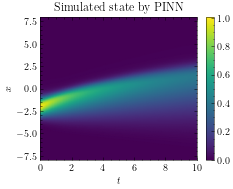

In [25]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, pinn_sim_sol, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("Simulated state by PINN", fontsize=12)
    cbar = ufig.colorbar(contour)
    ufig.savefig("../Figures/sim_burgers_PINN.pdf")
    ufig.savefig("../Figures/sim_burgers_PINN.png", dpi=300)
    plt.show()